In [1]:
import json
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

with open('metrics.json') as f:
    metrics = json.load(f)
seed = metrics['random_seed']
import os, random
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test  = np.load('X_test.npy')
y_test  = np.load('y_test.npy')

scaler = joblib.load('scaler.joblib')

def build_model(input_shape):
    m = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 2, activation='relu', padding='same'),
        BatchNormalization(), MaxPooling1D(2),
        Conv1D(64, 2, activation='relu', padding='same'),
        BatchNormalization(), MaxPooling1D(2),
        Conv1D(128,2, activation='relu', padding='same'),
        BatchNormalization(), MaxPooling1D(1),
        Flatten(),
        Dense(5, activation='linear'),
        Dropout(0.1),
        Dense(5, activation='linear'),
        Dense(1, activation='linear'),
    ])
    m.compile(optimizer='adam', loss='huber', metrics=['mse','mae'])
    return m

model = build_model(X_train.shape[1:])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=10, min_lr=1e-6, verbose=0.0001
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr],
    verbose=2
)

loss, mse, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Re-trained Test Loss (log): {loss:.6f}")
print(f"Re-trained Test MSE (log):  {mse:.6f}")
print(f"Re-trained Test MAE (log):  {mae:.6f}")

print("\nOriginal metrics from metrics.json:")
print(f"  Test Loss (log): {metrics['test_loss_log']}")
print(f"  Test MSE  (log): {metrics['test_mse_log']}")
print(f"  Test MAE  (log): {metrics['test_mae_log']}")

Epoch 1/100
200/200 - 2s - 10ms/step - loss: 1.2141 - mae: 1.6094 - mse: 5.3426 - val_loss: 0.3543 - val_mae: 0.7185 - val_mse: 0.7481 - learning_rate: 0.0010
Epoch 2/100
200/200 - 0s - 2ms/step - loss: 0.2138 - mae: 0.5161 - mse: 0.4841 - val_loss: 0.0748 - val_mae: 0.3174 - val_mse: 0.1496 - learning_rate: 0.0010
Epoch 3/100
200/200 - 0s - 2ms/step - loss: 0.1938 - mae: 0.4957 - mse: 0.4252 - val_loss: 0.0372 - val_mae: 0.2133 - val_mse: 0.0743 - learning_rate: 0.0010
Epoch 4/100
200/200 - 0s - 2ms/step - loss: 0.1545 - mae: 0.4471 - mse: 0.3288 - val_loss: 0.0316 - val_mae: 0.2043 - val_mse: 0.0632 - learning_rate: 0.0010
Epoch 5/100
200/200 - 0s - 2ms/step - loss: 0.1324 - mae: 0.4106 - mse: 0.2779 - val_loss: 0.0189 - val_mae: 0.1615 - val_mse: 0.0378 - learning_rate: 0.0010
Epoch 6/100
200/200 - 0s - 2ms/step - loss: 0.1147 - mae: 0.3828 - mse: 0.2385 - val_loss: 0.0309 - val_mae: 0.1936 - val_mse: 0.0618 - learning_rate: 0.0010
Epoch 7/100
200/200 - 0s - 2ms/step - loss: 0.0986 

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


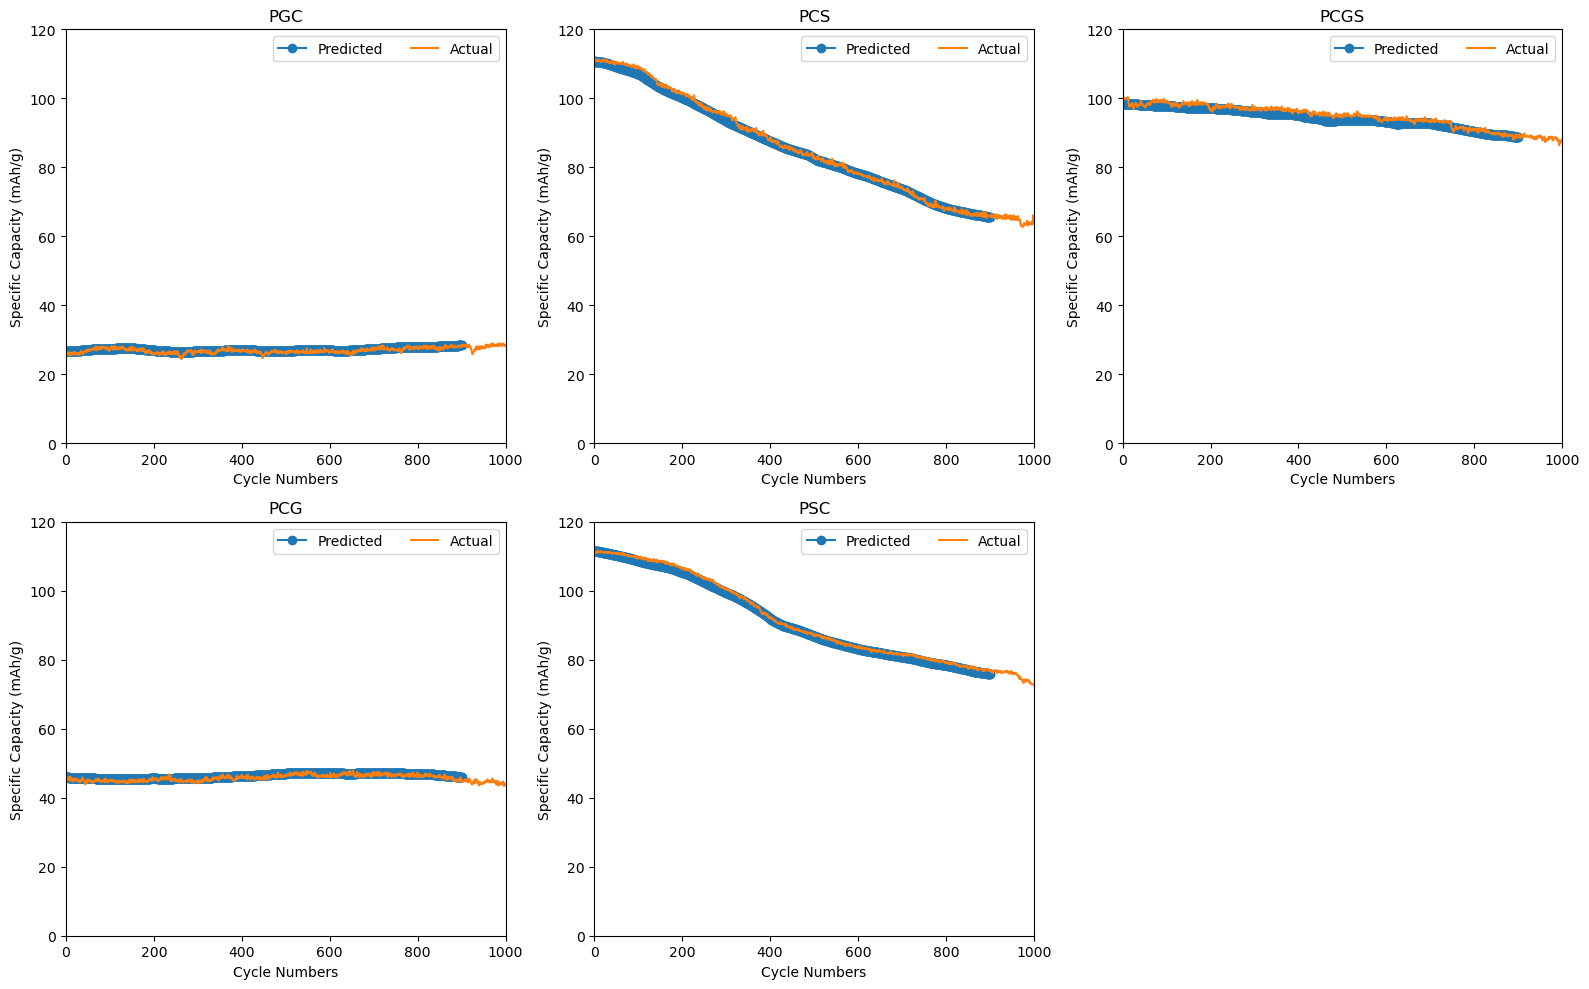

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = (
    pd.read_csv('train_valid_test.csv')
    .drop_duplicates()
)
df = df[df['CDC'] == 'discharge']

feat_cols = ['active_M', '2D_G', '1D_C', '0D_S', 'cycle_n']
target_col = 'SepCap_Cycle'

name_set = {'PGC', 'PCG', 'PCS', 'PSC', 'PCGS'}
mask = df['name'].isin(name_set) & (df['cycle_n'] <= 900)
df_valid_900 = df.loc[mask].drop_duplicates().copy()

X_val = scaler.transform(df_valid_900[feat_cols].values)[..., None]
df_valid_900['Predict_SepCap'] = np.expm1(model.predict(X_val).flatten())

plt.figure(figsize=(16, 10))
for i, nm in enumerate(name_set, start=1):
    sub_pred = df_valid_900[df_valid_900['name'] == nm]
    sub_act  = df[df['name'] == nm]
    ax = plt.subplot(2, 3, i)
    ax.plot(sub_pred['cycle_n'], sub_pred['Predict_SepCap'],
            marker='o', label='Predicted')
    ax.plot(sub_act ['cycle_n'], sub_act [target_col],
            label='Actual')
    ax.set(xlim=(0, 1000), ylim=(0, 120), title=nm,
           xlabel='Cycle Numbers', ylabel='Specific Capacity (mAh/g)')
    ax.legend(ncol=2)

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


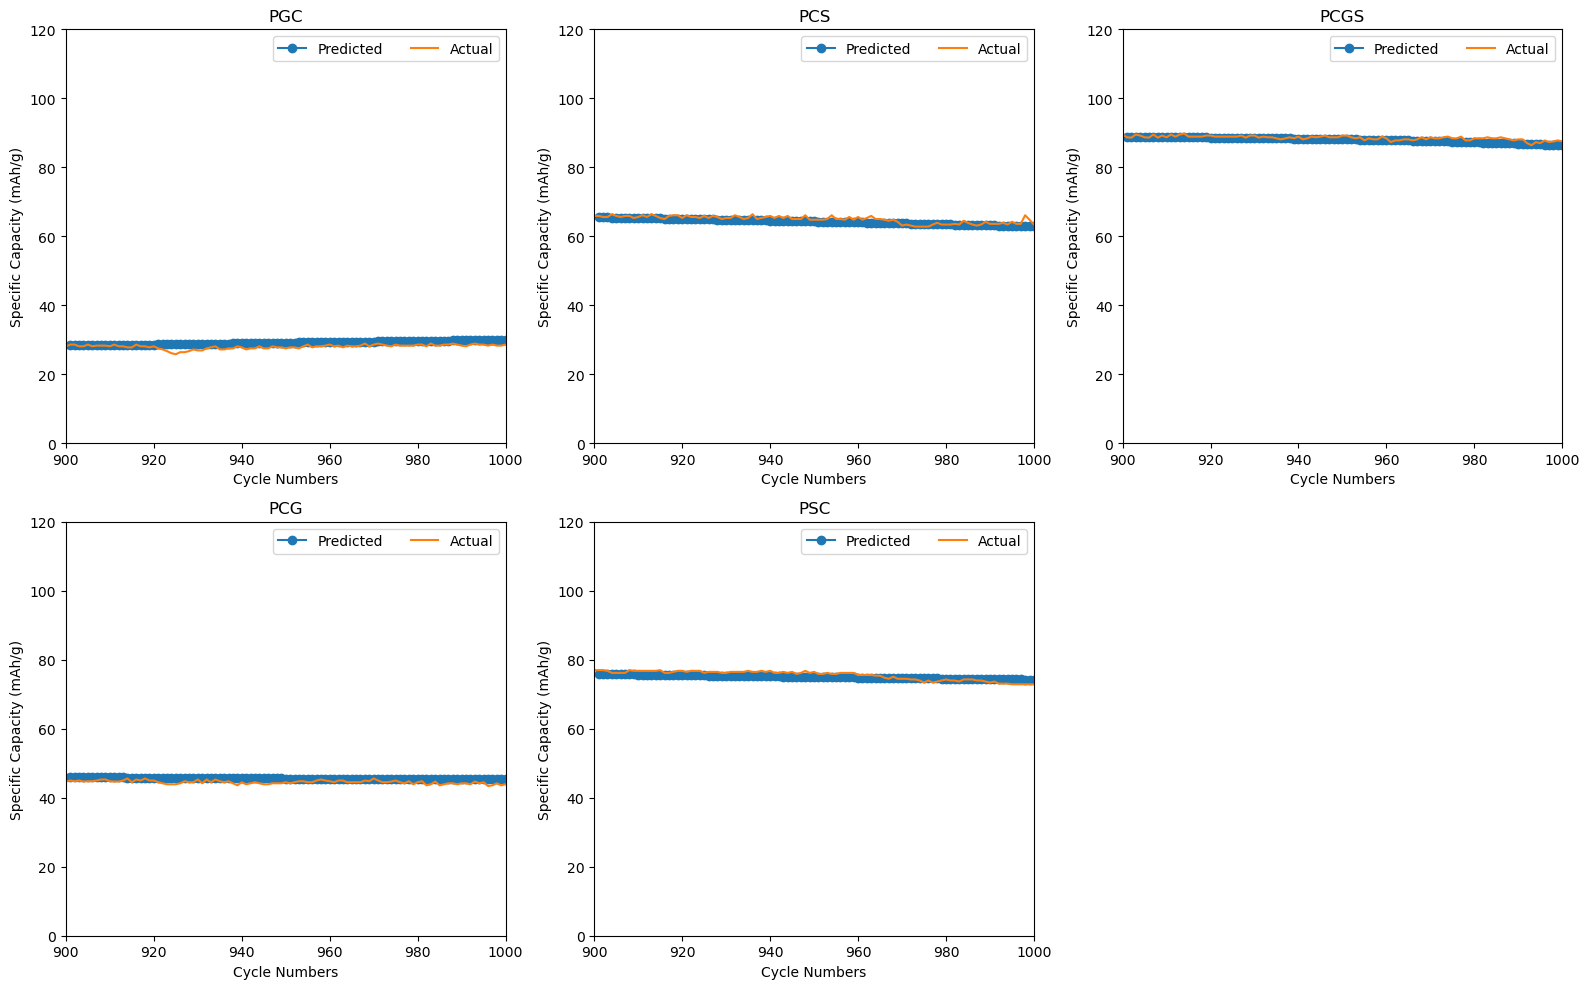

In [3]:
name_set = {'PGC', 'PCG', 'PCS', 'PSC', 'PCGS'}
mask = df['name'].isin(name_set) & (df['cycle_n'] > 900)
df_valid_900 = df.loc[mask].drop_duplicates().copy()

X_val = scaler.transform(df_valid_900[feat_cols].values)[..., None]
df_valid_900['Predict_SepCap'] = np.expm1(model.predict(X_val).flatten())

plt.figure(figsize=(16, 10))
for i, nm in enumerate(name_set, start=1):
    sub_pred = df_valid_900[df_valid_900['name'] == nm]
    sub_act  = df[df['name'] == nm]
    ax = plt.subplot(2, 3, i)
    ax.plot(sub_pred['cycle_n'], sub_pred['Predict_SepCap'],
            marker='o', label='Predicted')
    ax.plot(sub_act ['cycle_n'], sub_act [target_col],
            label='Actual')
    ax.set(xlim=(900, 1000), ylim=(0, 120), title=nm,
           xlabel='Cycle Numbers', ylabel='Specific Capacity (mAh/g)')
    ax.legend(ncol=2)

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


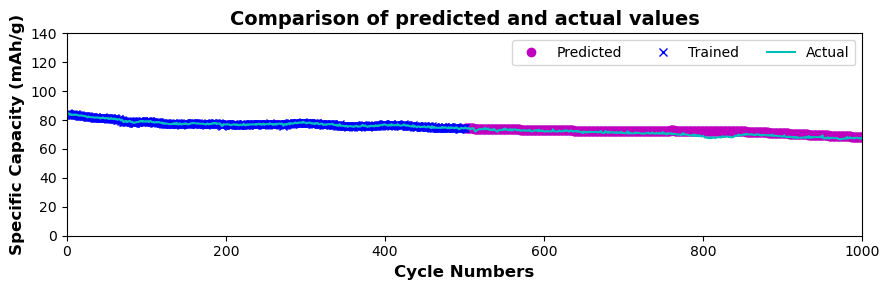

In [6]:
df_test2 = df[df['name']=='PSCG5'].drop_duplicates().copy()
X_test2  = scaler.transform(df_test2[feat_cols].values)[..., None]
df_test2['Predict_SepCap'] = np.expm1(model.predict(X_test2).flatten())

plt.figure(figsize=(9, 3))
mask = df_test2['cycle_n'] <= 500
plt.plot(df_test2.loc[~mask, 'cycle_n'], df_test2.loc[~mask, 'Predict_SepCap'], 'om', label='Predicted')
plt.plot(df_test2.loc[ mask, 'cycle_n'], df_test2.loc[ mask, 'SepCap_Cycle'],     'xb', label='Trained')
plt.plot(df_test2['cycle_n'],            df_test2['SepCap_Cycle'],            'c-', label='Actual')

plt.axis([0, 1000, 0, 140])
plt.title("Comparison of predicted and actual values", fontsize=14, fontweight="bold")
plt.xlabel("Cycle Numbers",       fontsize=12, fontweight="bold")
plt.ylabel("Specific Capacity (mAh/g)", fontsize=12, fontweight="bold")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()